# Brazil Sao Paulo sugarcane crop model using Gro API
In this notebook, we walk through the process of building a simple "crop model" using data in Gro. Our crop models use statistical or machine learning algorithms to predict crop yield of a speicific crop and regions. The accompanying Gro web app display for [Sao Paulo Sugarcane](https://app.gro-intelligence.com/displays/wZRlYJQ9B) provides an overview of the data series we will use to create a model to predict the sugar processing yield in Sao Paulo. 

## Preliminary
Here we use a `CropModel` object as well as some feature transformation functions. We also save the entity ids for the `item` [sugarcane](https://app.gro-intelligence.com/dictionary/items/538), `metric` [processing yield](https://app.gro-intelligence.com/dictionary/metrics/6881050), and for the `region` [Sao Paulo](https://app.gro-intelligence.com/dictionary/regions/10408).  We will use these throughout the notebook to simplify the retrieval, storage and manipulation of data.
In order to download data from our API, you need to set up a GROPI_TOKEN. Instructions are in this [wiki page](https://github.com/gro-intelligence/api-client/wiki/Authentication-Tokens#11-using-the-gro-web-application-preferred).

In [2]:
import logging
logging.basicConfig(level=logging.ERROR) 
import os
import numpy as np
import pandas as pd
import itertools
import datetime

from api.client.crop_model import CropModel
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.cluster import KMeans

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
country_id = model.search_for_entity('regions', "brazil")
region_id = model.search_for_entity('regions', "Sao Paulo")
item_id =  model.search_for_entity('items', "sugarcane, TRS")


##  Historical Sugar Processing yields
To get the province-level sucrose yield data for sugarcane in Sao Paulo state, we set the entities (item, metric and region) and get the available data series.  The <em>source</em> for Sao Paulo sugarcane yields is [UNICA](https://app.gro-intelligence.com/dictionary/sources/47).

In [3]:
yield_entities = {}
yield_entities['item_id']  = item_id
yield_entities['region_id'] = region_id
yield_entities['metric_id'] = model.search_for_entity('metrics', "processing yield mass/mass")
yield_entities['source_id'] = 47 # unica
data_series_list = model.get_data_series(**yield_entities)
print("There are {} data series for {}.".format(len(data_series_list), yield_entities))
for data_series in data_series_list:
    print("source_id {}: {} to {}".format(
        data_series['source_id'], data_series['start_date'], data_series['end_date']))
    model.add_single_data_series(data_series)

Added {u'end_date': u'2019-03-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World', u'frequency_id': 9, u'source_id': 47, u'partner_region_id': 0, u'item_id': 7539, u'metric_name': u'Processing Yield (mass/mass)', u'start_date': u'2007-04-01T00:00:00.000Z', u'metric_id': 6881050}
INFO:api.client.lib:Added {u'end_date': u'2019-03-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World', u'frequency_id': 9, u'source_id': 47, u'partner_region_id': 0, u'item_id': 7539, u'metric_name': u'Processing Yield (mass/mass)', u'start_date': u'2007-04-01T00:00:00.000Z', u'metric_id': 6881050}
Added {u'end_date': u'2019-08-15T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World'

There are 2 data series for {'item_id': 7539, 'source_id': 47, 'region_id': 10408, 'metric_id': 6881050}.
source_id 47: 2007-04-01T00:00:00.000Z to 2019-03-31T00:00:00.000Z
source_id 47: 2008-04-01T00:00:00.000Z to 2019-08-15T00:00:00.000Z


* As printed above, there are 2 available data series for the Sugar processing yield of Sao Paulo
* Next we retrieve the data frame of the sugarcane total recoverable sugars (TRS) series and make sure to subset to the metric (Processing Yield (mass/mass)), semi-monthly frequency and region (Sao Paulo) 

In [7]:

df = model.get_df()
yield_df = df.loc[(df.metric_id == yield_entities['metric_id']) & \
                  (df.region_id == yield_entities['region_id']) & \
                  (df.frequency_id == 23)
                 ]
yield_df.end_date = pd.to_datetime(yield_df.end_date, utc=True)
yield_df['DOY']  = yield_df.end_date.apply(lambda x: int(x.strftime('%j')))
yield_df['Year'] = yield_df.end_date.apply(lambda x: x.year)
yield_df.sort_values(['Year', 'DOY']).tail()



,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,value,DOY,Year
217,2019-06-15 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-06-01T00:00:00.000Z,866,117.480458,166,2019
218,2019-06-30 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-06-16T00:00:00.000Z,866,122.388328,181,2019
219,2019-07-15 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-07-01T00:00:00.000Z,866,124.565572,196,2019
220,2019-07-31 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-07-16T00:00:00.000Z,866,128.611617,212,2019
221,2019-08-15 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-08-01T00:00:00.000Z,866,131.813981,227,2019


* The resulting data frame includes information on the start and end date of the periods corresponding to each processing yield observation, and ids representing the frequency, unit, unit scale, item, metric, and region of our Gro data series. 
**Note**: the unit used here for TRS is kg/ton or kilograms per **US short ton**, not the metric tonnes. 
* The Day of Year and Year columns are derived from the end_date column to help with feature transformation processing

* A scatter plot helps us visualize the progression of the TRS processing yield over time. We suspect that it follows similar seasonal patterns in all years and more recent years might be higher in TRS than years further back. 
* So, we plot the following figure of TRS versus the day of year and color coded by year.  

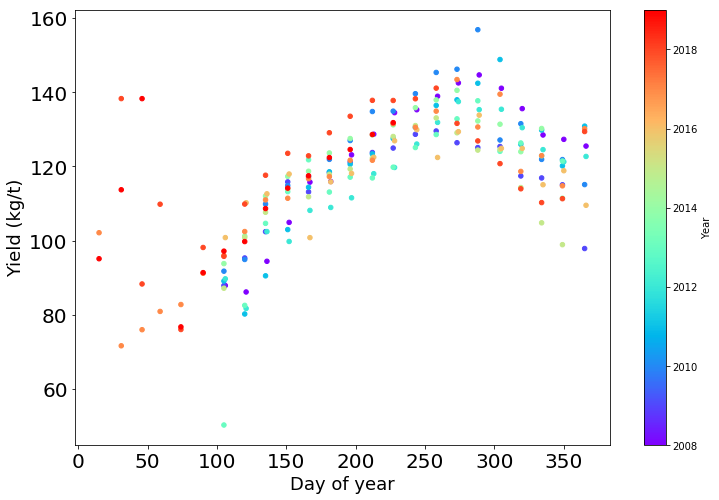

In [9]:
fig, axes = plt.subplots(1, 1)
yield_df[yield_df['value']<300].plot(x='DOY', y='value', kind='scatter', c='Year', 
                                     cmap='rainbow', ax=axes, figsize=(12,8), fontsize=20, legend=True)
plt.xlabel("Day of year", fontsize=18)
plt.ylabel("Yield (kg/t)", fontsize=18)
plt.show()

* As we can see in this figure above, the sugar processing yield follows an increasing pattern from the Day of year (DOY) 100 to about 270 and then goes back down 
* The processing yield between the DOY 350 and DOY 100 of the following year appear to show no pattern, and there are only data points for recent years
* For the purpose of this analysis, we therefore limit the study period to between the DOY 100 and 350
* **Note**: It is possible to limit the time period of the data being pulled. You just need to specify 'start_date' and 'end_date' in the entities dictionary that we used earlier as inputs to the CropModel <i>get_data_series<i> method

In [10]:
df_within_range = yield_df[(yield_df['DOY'] > 100) & (yield_df['DOY'] < 350)]

* In case of making a TRS forecast for a period in the future, we generate an additional dataframe of the new dates. For example, here we add a date that occurs 15 days after the most recent available TRS period in order to make a forecast for that period.

In [11]:
# date to predict
new_date = df_within_range['end_date'].max() + datetime.timedelta(days=15)
print(new_date.strftime('%Y-%m-%d'))

2019-08-30


In [12]:
# expand the df_within_range with this new date
unknown_df = df_within_range.set_index('end_date').reindex([new_date]).reset_index()
unknown_df['DOY']  = unknown_df.end_date.apply(lambda x: int(x.strftime('%j')))
unknown_df['Year'] = unknown_df.end_date.apply(lambda x: x.year)
df_within_range = pd.concat([df_within_range, unknown_df
                             ], ignore_index=True)


* Next, convert the end_date column to datetime 
* Convert the DOY and Year columns to integers type

In [13]:
df_within_range['end_date'] = pd.to_datetime(df_within_range['end_date'], utc=True)
df_within_range.DOY = df_within_range.DOY.astype(int)
df_within_range.Year = df_within_range.Year.astype(int)
df_within_range.rename(columns={'value': 'TRS'}, inplace=True)
df_within_range.tail()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,TRS,DOY,Year
189,2019-06-30 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-16T00:00:00.000Z,866.0,122.388328,181,2019
190,2019-07-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-01T00:00:00.000Z,866.0,124.565572,196,2019
191,2019-07-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-16T00:00:00.000Z,866.0,128.611617,212,2019
192,2019-08-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-08-01T00:00:00.000Z,866.0,131.813981,227,2019
193,2019-08-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242,2019


## NDVI of Sao Paulo
The main signal we will use to model TRS yields is [NDVI](https://app.gro-intelligence.com/dictionary/items/321), which represents vegetation biomass per pixel, and thus is a good physical proxy for vegetative growth (production mass per unit of area).

First we load the historical data for province level NDVI.  Here, there  are actually two data series for each region, one with `8-day` and one with `16-day` periods. We choose to use the series with 8-day (frequency_id = 3).

In [14]:
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Vegetation NDVI")
entities['metric_id'] = model.search_for_entity('metrics', "Vegetation Indices index")
entities['frequency_id'] = 3


entities['region_id'] = region_id
for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)

Added {u'end_date': u'2019-09-05T00:00:00.000Z', u'source_name': u'GIMMS MODIS NDVI', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Vegetation (NDVI)', u'partner_region_name': u'World', u'frequency_id': 3, u'source_id': 3, u'partner_region_id': 0, u'item_id': 321, u'metric_name': u'Vegetation Indices', u'start_date': u'2000-02-18T00:00:00.000Z', u'metric_id': 70029}
INFO:api.client.lib:Added {u'end_date': u'2019-09-05T00:00:00.000Z', u'source_name': u'GIMMS MODIS NDVI', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Vegetation (NDVI)', u'partner_region_name': u'World', u'frequency_id': 3, u'source_id': 3, u'partner_region_id': 0, u'item_id': 321, u'metric_name': u'Vegetation Indices', u'start_date': u'2000-02-18T00:00:00.000Z', u'metric_id': 70029}


In [15]:
df = model.get_df()
raw_ndvi = df[(df['item_id'] == entities['item_id']) & (df['metric_id']==entities['metric_id'])]
raw_ndvi.head()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,reporting_date,start_date,unit_id,value
0,2000-02-25T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-02-18T00:00:00.000Z,189,0.762697
1,2000-03-04T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-02-26T00:00:00.000Z,189,0.695848
2,2000-03-12T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-03-05T00:00:00.000Z,189,0.691231
3,2000-03-20T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-03-13T00:00:00.000Z,189,0.687999
4,2000-03-28T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-03-21T00:00:00.000Z,189,0.712319


* A quick way to summarize the statistics of this NDVI dataframe is to use the *describe()* method.
* As shown in the table below, there are 889 data points and the mean NDVI value is 0.63 with a standard deviation of 0.079, a min of 0.386, and a max of 0.76.

In [16]:
raw_ndvi.describe()

,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value
count,892.0,892.0,892.0,892.0,892.0,892.0,892.0,892.000000
mean,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.629765
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079043
min,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.386523
25%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.566646
50%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.649464
75%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.698189
max,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.762697


* The start and end dates of individual NDVI periods do not match with that of the Sugar processing yield periods because NDVI data is reported in 8-day periods while the TRS series is reported in 15-day periods.
* In order to synchronize these two data series, we transform the NDVI data to a daily time step first and then pick the NDVI value that corresponds to the sugar processing yield data periods' end dates.
* The way we transform NDVI is a linear interpolation method. The reasoning is that NDVI is an indicator of the amount of biomass, which generally varies continuously as the vegetation grows.

In [17]:
# transform the 8-day data into a daily dataframe
date_index = 'end_date'
startday = 100
endday = 350
region_index='region_id'
feature = 'value'
raw_ndvi[date_index] = pd.to_datetime(raw_ndvi[date_index], utc=True)
min_date = raw_ndvi[date_index].min()
max_date = pd.to_datetime("{}-{}".format(raw_ndvi[date_index].max().year, endday), 
                          format='%Y-%j', utc=True)
date_range = pd.date_range(min_date, max_date, freq='D', name=date_index)
raw_ndvi_pivot = raw_ndvi.pivot_table(index=date_index, columns=region_index, values=feature)

raw_ndvi_filled = raw_ndvi_pivot.reset_index().set_index(date_index).reindex(
    date_range).asfreq('D').interpolate(
    method='linear',limit_direction='forward', axis=0).stack(   
    region_index).reset_index(name=feature)
raw_ndvi_filled.describe()

,region_id,value
count,7235.0,7235.000000
mean,10408.0,0.628216
std,0.0,0.078831
min,10408.0,0.386523
25%,10408.0,0.561407
50%,10408.0,0.645618
75%,10408.0,0.697275
max,10408.0,0.762697


* The data frame printed above shows the result of applying linear interpolation of NDVI from 8-day periods to daily timestep
* Next, subset the NDVI data to our study timeframe between the DOY 100 and 350

In [18]:
# Get the Doy of year (DOY) as well as Year from the date index
raw_ndvi_filled.loc[:, 'doy'] = raw_ndvi_filled[date_index].dt.dayofyear
raw_ndvi_filled.loc[:, 'year'] = raw_ndvi_filled[date_index].dt.year
ndvi_within_range = raw_ndvi_filled[(raw_ndvi_filled['doy'] > 100) & (
    raw_ndvi_filled['doy'] < 350)]


* And then merge together the NDVI data frame with the TRS or sugar processing yield data frame.
* Keep the NDVI values of the dates that match with the TRS period end dates.

In [19]:
ndvi_within_range.rename(columns={'value': 'ndvi'}, inplace=True)
ndvi_df = ndvi_within_range[ndvi_within_range['year'].isin(df_within_range['Year'].unique())]


ndvi_df.loc[:, 'DOY'] = ndvi_df.doy.astype(int)
ndvi_df.loc[:, 'Year'] = ndvi_df.year.astype(int)

ndvi_y = df_within_range[['DOY','Year','TRS']].merge(ndvi_df[['end_date','doy','year', 'ndvi']],
                        left_on=['DOY','Year'], right_on= ['doy','year'], how='left')
ndvi_y.tail()


,DOY,Year,TRS,end_date,doy,year,ndvi
189,181,2019,122.388328,2019-06-30 00:00:00+00:00,181,2019,0.637306
190,196,2019,124.565572,2019-07-15 00:00:00+00:00,196,2019,0.607610
191,212,2019,128.611617,2019-07-31 00:00:00+00:00,212,2019,0.562770
192,227,2019,131.813981,2019-08-15 00:00:00+00:00,227,2019,0.551480
193,242,2019,NaN,2019-08-30 00:00:00+00:00,242,2019,0.502590


* A scatter plot of TRS versus NDVI that is color coded by the Day of Year (DOY) indicates: the relationship between the two variables along with different patterns or relationships during different periods of the year.

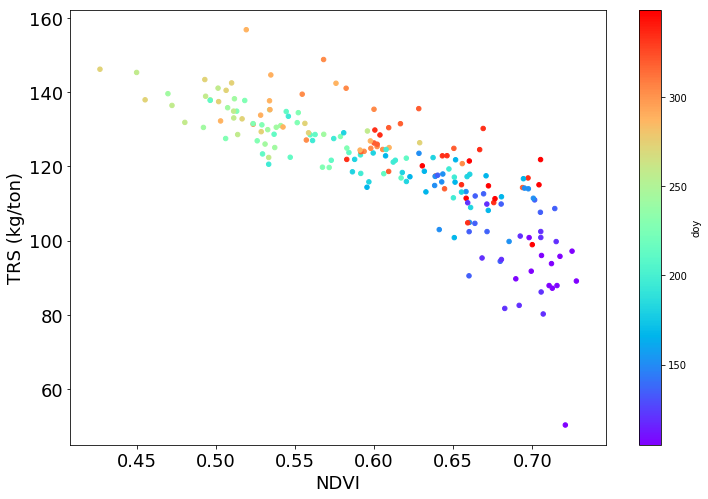

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
        
ndvi_y.plot(x='ndvi', y='TRS', c='doy', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('NDVI', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()

* As shown in this figure above, there is an inverse relationship between the content of Total Recoverable Sugar (TRS) and the NDVI values.
* This negative correlation has greater magnitude (a steeper slope) during earlier DOY than the rest of the year

### Daily FEWS_PET versus Sugar Content
In addition to NDVI, there are various climate features that may be able to capture variation in the sugar processing yield. The potential evapotranspiration is one important measurement: [FEWS_PET](https://app.gro-intelligence.com/dictionary/items/5072)

In [21]:
entities = {}
entities['item_id'] =  5072
entities['metric_id'] = 4660031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 44
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)


Added {u'end_date': u'2019-09-08T00:00:00.000Z', u'source_name': u'FEWS PET', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Potential evapotranspiration (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 44, u'partner_region_id': 0, u'item_id': 5072, u'metric_name': u'Evapotranspiration Value', u'start_date': u'2008-01-01T00:00:00.000Z', u'metric_id': 4660031}
INFO:api.client.lib:Added {u'end_date': u'2019-09-08T00:00:00.000Z', u'source_name': u'FEWS PET', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Potential evapotranspiration (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 44, u'partner_region_id': 0, u'item_id': 5072, u'metric_name': u'Evapotranspiration Value', u'start_date': u'2008-01-01T00:00:00.000Z', u'metric_id': 4660031}


In [22]:
model.get_df()
raw_pet = model._data_frame[model._data_frame['metric_id'] == 4660031]
raw_pet.tail()


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,reporting_date,start_date,unit_id,value
4264,2019-09-04T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-09-04T00:00:00.000Z,2,3.739600
4265,2019-09-05T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-09-05T00:00:00.000Z,2,3.869424
4266,2019-09-06T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-09-06T00:00:00.000Z,2,4.480388
4267,2019-09-07T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-09-07T00:00:00.000Z,2,5.463619
4268,2019-09-08T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-09-08T00:00:00.000Z,2,5.471657


In [23]:
raw_pet.loc[:, date_index] = pd.to_datetime(raw_pet[date_index], utc=True)

raw_pet.loc[:, 'doy'] = raw_pet[date_index].dt.dayofyear
raw_pet.loc[:, 'year'] = raw_pet[date_index].dt.year


* Since PET is available at daily time step, we are able to directly aggregate it to match with the same periods of the Sugar processing yield or TRS dataset.
* First, merge the DOY information from the TRS dataset, and then aggregate PET (sum) to those periods.

In [38]:
START_YEAR = df_within_range['Year'].min()

pet_agg = raw_pet[['doy','year', 'value']].merge(df_within_range[['DOY','Year','TRS']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')
pet_agg = pet_agg[pet_agg['year'] >= START_YEAR][pet_agg['doy']>=100][pet_agg['doy']<=350]
pet_grouped = pet_agg.fillna(method='bfill').groupby(['year','DOY']).sum().reset_index()

pet_y = df_within_range.merge(pet_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
pet_y.sort_values(['Year','DOY']).tail()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,TRS,DOY,Year,value,year
189,2019-06-30 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-16T00:00:00.000Z,866.0,122.388328,181,2019,40.207118,2019
190,2019-07-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-01T00:00:00.000Z,866.0,124.565572,196,2019,35.686268,2019
191,2019-07-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-16T00:00:00.000Z,866.0,128.611617,212,2019,45.571318,2019
192,2019-08-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-08-01T00:00:00.000Z,866.0,131.813981,227,2019,50.138107,2019
193,2019-08-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242,2019,56.892302,2019


* Next we use a color coded scatter plot to show the relationship between TRS and PET.

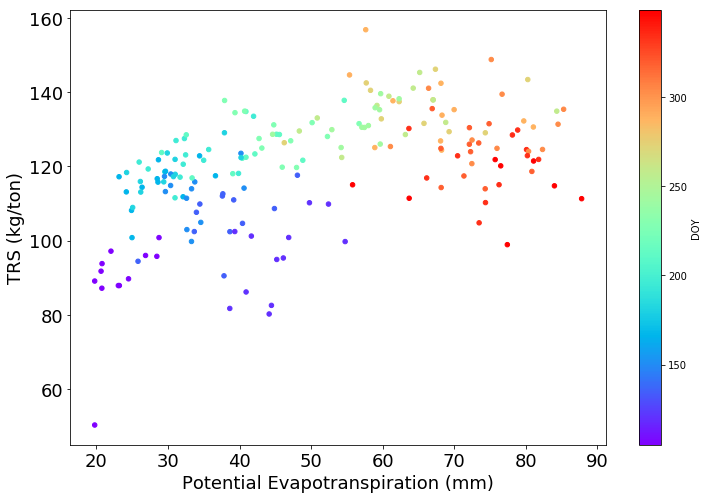

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
        
pet_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('Potential Evapotranspiration (mm)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* There appears to be a positive relationship between TRS and PET for the DOY between 170 to 260.
* The rest of the days of a year appeared to show a much weaker relationship.

### Daily TRMM precipitation versus Sugar Content
Daily precipitation is another weather variable that proved to be important to the sugar processing yield.
[TRMM](https://app.gro-intelligence.com/dictionary/sources/35)
[Precipitation](https://app.gro-intelligence.com/dictionary/items/10081)

In [26]:
entities = {}
entities['item_id'] =  10081
entities['metric_id'] = 2100031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 35
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    if data_series['region_id']==region_id:
        model.add_single_data_series(data_series)


Added {u'end_date': u'2019-09-09T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-09-09T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled) 10-yr mean (2001

In [27]:
model.get_df()
raw_trmm = model._data_frame[(model._data_frame['metric_id'] == 2100031) & (
    model._data_frame['item_id'] == 2039)]
raw_trmm[date_index] = pd.to_datetime(raw_trmm[date_index], utc=True)

raw_trmm.loc[:, 'doy'] = raw_trmm[date_index].dt.dayofyear
raw_trmm.loc[:, 'year'] = raw_trmm[date_index].dt.year

raw_trmm.describe()

,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value,doy,year
count,7132.0,7132.0,7132.0,7132.0,7132.0,7132.0,7132.0,7132.000000,7132.000000,7132.000000
mean,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,3.894708,182.414891,2009.428351
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.119488,104.506515,5.645121
min,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.000000,1.000000,2000.000000
25%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.041918,93.000000,2005.000000
50%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.783631,182.000000,2009.000000
75%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,5.634466,272.000000,2014.000000
max,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,54.555632,366.000000,2019.000000


* Similar to PET, TRMM is also a data source at the daily timestep. So, we follow a similar procedure to aggregate (sum) it to the same periods as the TRS dataset.

In [28]:
trmm_agg = raw_trmm[['doy','year', 'value']].merge(df_within_range[['DOY','Year','TRS']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')
trmm_agg = trmm_agg[trmm_agg['year'] >= START_YEAR][trmm_agg['doy']>=100][trmm_agg['doy']<=350]


trmm_grouped = trmm_agg.fillna(method='bfill').groupby(['DOY','year']).sum().reset_index()

trmm_y = df_within_range.merge(trmm_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
trmm_y.tail()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,TRS,DOY,Year,value,year
189,2019-06-30 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-16T00:00:00.000Z,866.0,122.388328,181,2019,2.331407,2019
190,2019-07-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-01T00:00:00.000Z,866.0,124.565572,196,2019,27.600461,2019
191,2019-07-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-16T00:00:00.000Z,866.0,128.611617,212,2019,6.312553,2019
192,2019-08-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-08-01T00:00:00.000Z,866.0,131.813981,227,2019,7.815691,2019
193,2019-08-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242,2019,4.906262,2019


* Next, we use a scatter plot to show the relationship between TRS and TRMM precipitation.

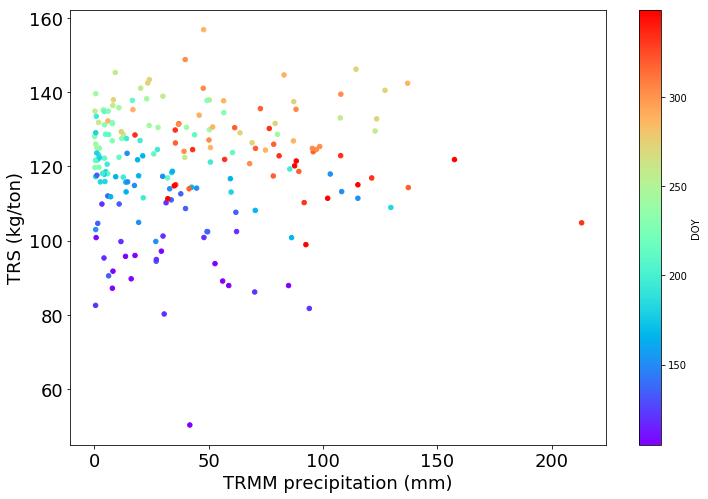

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
        
trmm_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('TRMM precipitation (mm)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* As shown in the scatter plot above, there appears to be a mild negative relationship between TRS and TRMM precipitation in the period following DOY 300 and in the period preceding DOY 200.

### Daily LST temperature versus Sugar Content
The Land Surface Temperature ([LST](https://app.gro-intelligence.com/dictionary/sources/26)) is a daily timestep temperature data source.


In [30]:
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Land temperature")
entities['metric_id'] = model.search_for_entity('metrics', "Temperature")
entities['region_id'] = region_id
entities['frequency_id']= 1

for data_series in model.get_data_series(**entities):
    if data_series['region_id'] == region_id :
        model.add_single_data_series(data_series)


Added {u'end_date': u'2019-09-08T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-09-08T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}


* Again, we aggregate (average) the LST temperature data to the same periods as the TRS sugar processing yield data.

In [31]:
model.get_df()
raw_lst = model._data_frame[model._data_frame['metric_id'] == entities['metric_id']]
print(raw_lst.end_date.unique())
raw_lst.loc[:, date_index] = pd.to_datetime(raw_lst[date_index], utc=True)

raw_lst.loc[:, 'doy'] = raw_lst[date_index].dt.dayofyear
raw_lst.loc[:, 'year'] = raw_lst[date_index].dt.year

raw_lst.describe()

[u'2000-02-25T00:00:00.000Z' u'2000-02-26T00:00:00.000Z'
 u'2000-02-27T00:00:00.000Z' ... u'2019-09-06T00:00:00.000Z'
 u'2019-09-07T00:00:00.000Z' u'2019-09-08T00:00:00.000Z']


,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value,doy,year
count,6993.0,6993.0,6993.0,6993.0,6993.0,6993.0,6993.0,6940.000000,6993.000000,6993.000000
mean,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,26.816753,182.380237,2009.451737
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.352550,104.405840,5.632124
min,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,11.082408,1.000000,2000.000000
25%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,23.961362,93.000000,2005.000000
50%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,26.799788,182.000000,2009.000000
75%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,29.799316,272.000000,2014.000000
max,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,42.230718,366.000000,2019.000000


In [41]:
lst_agg = raw_lst[['end_date','value', 'doy','year']].merge(df_within_range[['end_date','DOY']],
                        on='end_date' , how='left').drop_duplicates()
lst_agg = lst_agg[lst_agg['year'] >= START_YEAR][lst_agg['doy']>=100][lst_agg['doy']<=350]


lst_grouped = lst_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()

lst_y = df_within_range.merge(lst_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
lst_y.tail()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,TRS,DOY,Year,value,year
189,2019-06-30 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-16T00:00:00.000Z,866.0,122.388328,181,2019,25.639388,2019
190,2019-07-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-01T00:00:00.000Z,866.0,124.565572,196,2019,22.390140,2019
191,2019-07-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-16T00:00:00.000Z,866.0,128.611617,212,2019,23.372214,2019
192,2019-08-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-08-01T00:00:00.000Z,866.0,131.813981,227,2019,25.983064,2019
193,2019-08-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242,2019,27.726499,2019


* Again, we plot a scatter plot of TRS versus LST to visualize the relationship between total recoverable sugar and the land surface temperature.

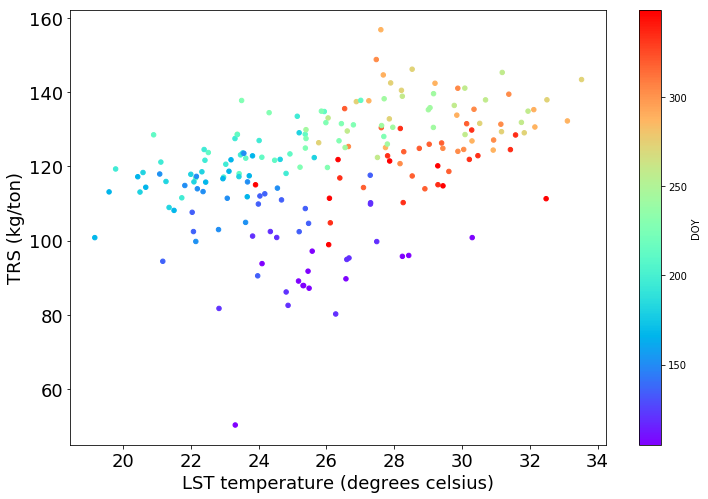

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
        
lst_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('LST temperature (degrees celsius)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* The LST appears to be positively correlated with the TRS, especially for the DOY between 170 and 270

### Merge the variables together and assess the relationships among them

In [34]:
pet_y.rename(columns={'value': 'pet'}, inplace=True)
trmm_y.rename(columns={'value': 'trmm'}, inplace=True)
lst_y.rename(columns={'value': 'lst'}, inplace=True)
pet_y.DOY = pet_y.DOY.astype(int)
trmm_y.DOY = trmm_y.DOY.astype(int)
lst_y.DOY = lst_y.DOY.astype(int)
df_tog = ndvi_df.merge(pet_y[['pet', 'DOY','year', 'TRS']], on=['DOY', 'year'], how='inner'
                    ).merge(trmm_y[['trmm', 'DOY','year']], on=['DOY', 'year'], how='left'
                    ).merge(lst_y[['lst', 'DOY','year']], on=['DOY', 'year'], how='left'
                    )

df_tog.sort_values(['year','DOY'], ascending=True).tail()

,end_date,region_id,ndvi,doy,year,DOY,Year,pet,TRS,trmm,lst
189,2019-06-30 00:00:00+00:00,10408,0.637306,181,2019,181,2019,40.207118,122.388328,2.331407,25.639388
190,2019-07-15 00:00:00+00:00,10408,0.607610,196,2019,196,2019,35.686268,124.565572,27.600461,22.390140
191,2019-07-31 00:00:00+00:00,10408,0.562770,212,2019,212,2019,45.571318,128.611617,6.312553,23.372214
192,2019-08-15 00:00:00+00:00,10408,0.551480,227,2019,227,2019,50.138107,131.813981,7.815691,25.983064
193,2019-08-30 00:00:00+00:00,10408,0.502590,242,2019,242,2019,56.892302,NaN,4.906262,27.726499


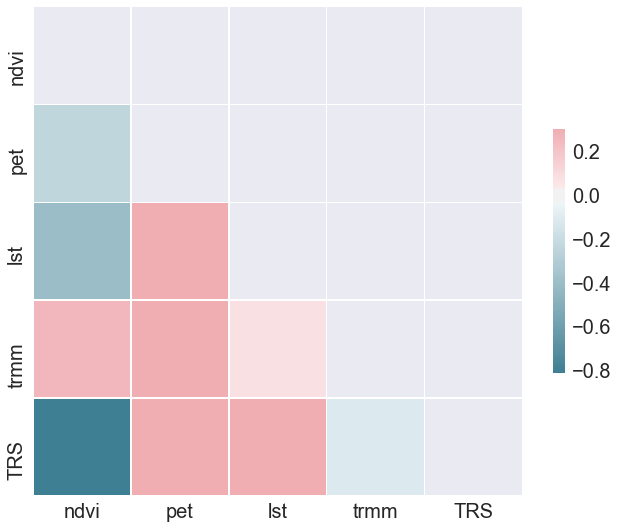

In [39]:

corr = df_tog[['ndvi','pet','lst', 'trmm','TRS']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=2) 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* NDVI is positively correlated with precipitation and negatively correlated with LST and PET.
* PET, as a modeled product with temperature and precipitation as major inputs, is positively correlated with LST and TRMM.
* Temperature appears to be mildly positively correlated with precipitation, which is because the dry season corresponds to the winter or colder season in the southern atmosphere, or Sao Paulo here.

### Cluster the points to find the distinct periods during the season
* The previous scatter plots between TRS and weather variables manifested three clusters of DOY periods.
* Because of such differing responses of TRS to weather conditions at different time of the year, it is appropriate to model those three periods separately.
* First, we need to clearly define the boundaries of those three clusters, and KMeans is a simple clustering method to do so.

In [25]:

X = np.array(df_tog[['ndvi','pet','lst', 'trmm','TRS','DOY']].dropna())
f_names = ['ndvi','pet','lst', 'trmm','TRS','DOY']
kmeans = KMeans(3)
kmeans.fit(X)
# save new clusters for chart
y_km = kmeans.fit_predict(X)

* Add a variable name `group` to record the KMeans clustering result, as printed below

In [26]:
data_decision = pd.DataFrame(X)
data_decision.columns = f_names
data_decision['group'] = y_km
data_decision.head()

,ndvi,pet,lst,trmm,TRS,DOY,group
0,0.715580,3.294363,25.309613,12.132686,87.897155,106.0,1
1,0.705581,2.727573,24.810822,4.674732,86.164431,121.0,1
2,0.679714,1.720972,21.170560,1.804685,94.437959,136.0,1
3,0.660312,2.161575,23.613483,1.212690,104.925017,152.0,1
4,0.651189,1.906621,22.436543,0.919376,115.774950,167.0,1


In [27]:
print(data_decision.groupby('group').min())
data_decision.groupby('group').max()

           ndvi       pet        lst      trmm         TRS    DOY
group                                                            
0      0.426879  3.082981  23.907087  0.399399   98.919452  273.0
1      0.595553  1.544240  19.164008  0.038529   50.303408  105.0
2      0.450034  1.614573  19.779119  0.012298  108.943847  181.0


,ndvi,pet,lst,trmm,TRS,DOY
group,,,,,,
0,0.705202,5.853101,33.526674,14.202166,156.861358,349.0
1,0.727826,4.106493,30.300360,12.132686,123.540453,167.0
2,0.661019,5.621423,31.948077,8.642510,145.340109,259.0


We see that the three clusters of periods are the following
* period DOY 100-182
* period DOY 196-259
* period DOY 273-350

Cutoff DOY between periods: 190, 265.
Next, we visualize the relationship between all combinations of variables colored by the clustering groups

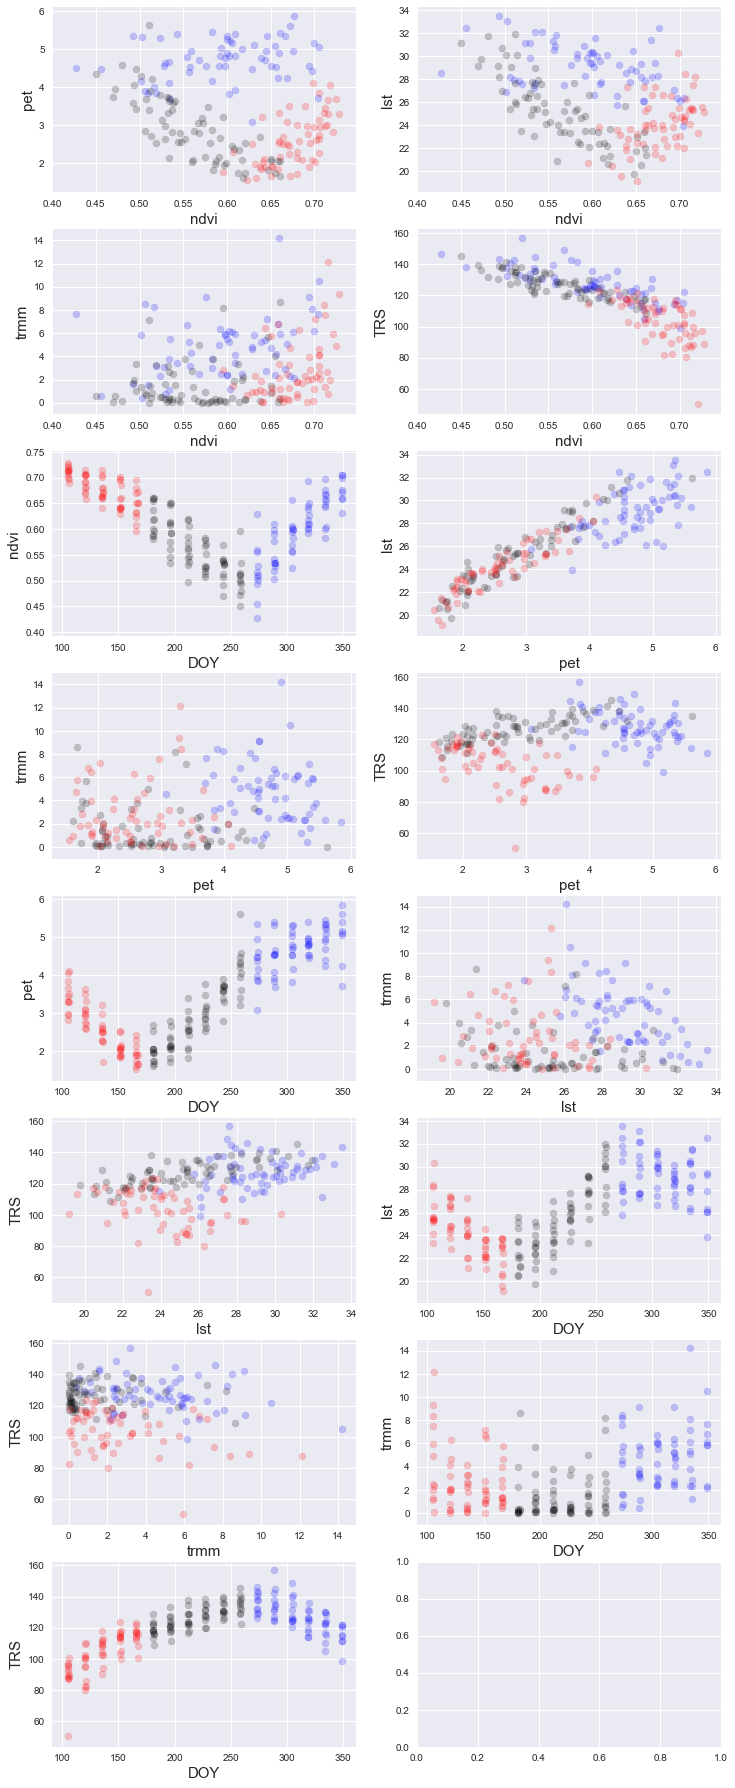

In [43]:
combos = [l for l in itertools.combinations(f_names,2)]

n_vars = len(combos)
n_rows = n_vars//2 + n_vars%2
sns.set(font_scale=1) 
alpha = 0.2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows*4))
for i in range(n_vars):
    ax = axes[i//2, i % 2]
    var_1, var2 = combos[i]
    if 'DOY' in combos[i]:
        var_1 = 'DOY'
        var2 = (set(combos[i]) - {'DOY'}).pop()
    ax.scatter(X[y_km ==0,f_names.index(var_1)], X[y_km == 0,f_names.index(var2)], s=50, c='blue', alpha = alpha)
    ax.scatter(X[y_km ==1,f_names.index(var_1)], X[y_km == 1,f_names.index(var2)], s=50, c='black', alpha = alpha)
    ax.scatter(X[y_km ==2,f_names.index(var_1)], X[y_km == 2,f_names.index(var2)], s=50, c='red', alpha = alpha)
    ax.set_xlabel(var_1, fontsize=15)
    ax.set_ylabel(var2, fontsize=15)

* The earliest group is shown in red. The middle group is shown in blue, and the latest group is in black.
* Seasonality is also clearly portrayed by the temperature, precipitation and PET from the DOY 100 to 350.

### Fit a multivariate linear regression for each Sub-harvesting-season
* There are many models we could choose to predict TRS
* A multivariate linear regression is a simplest method. It is easy to interpret and fast to run.
* The statsmodels package provides detailed regression statistics. We use the OLS (ordinary least squares) regressor here.

In [45]:
for name in ['lst','pet','trmm','ndvi','TRS']:
    df_tog[name] = df_tog[name].astype(float)

In [46]:
new_dat_list = []    
model_list = []
ranges = [(100, 190), (190, 265), (265,350)]
for L, R in ranges:
    sub_dat = df_tog[df_tog['DOY'] > L][df_tog['DOY'] < R].dropna()
    sub_dat['intercept'] = 1.
    X = sub_dat[['lst','pet','trmm','ndvi','intercept']]
    Y = sub_dat['TRS']
    # with statsmodels
    model = sm.OLS(Y, X).fit()
    sub_dat['pred'] = model.predict(X) 
    new_dat_list.append(sub_dat)
    model_list.append(model)
    print("TRS periods with DOY {} to {}".format(L, R))
    print(model.summary())
with_pred = pd.concat(new_dat_list, axis=0)#.drop_duplicates()


TRS periods with DOY 100 to 190
                            OLS Regression Results                            
Dep. Variable:                    TRS   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     16.72
Date:                Tue, 10 Sep 2019   Prob (F-statistic):           1.50e-09
Time:                        15:24:56   Log-Likelihood:                -264.63
No. Observations:                  72   AIC:                             539.3
Df Residuals:                      67   BIC:                             550.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lst           -0.492

* The middle period linear regression model (DOY 196-259) appeared to have the best performance in terms of the variance explained
* The following scatter plot shows the within-sample predicted versus actual yield along the 1-1 line

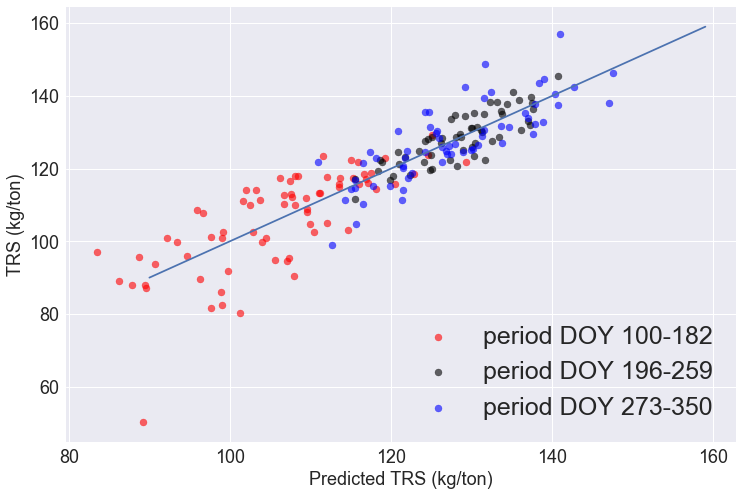

In [55]:
sns.set(font_scale=2.5) 
fig, ax = plt.subplots(figsize=(12,8))
with_pred[with_pred['DOY'] < 190].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='red', alpha=0.6)
with_pred[(with_pred['DOY'] > 190) & (with_pred['DOY'] < 265)].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='black', alpha=0.6)
with_pred[with_pred['DOY'] >270].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='blue', alpha=0.6)
plt.legend(['period DOY 100-182',
'period DOY 196-259',
'period DOY 273-350'])
ax.plot(range(90,160), range(90,160))
plt.xlabel('Predicted TRS (kg/ton)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()

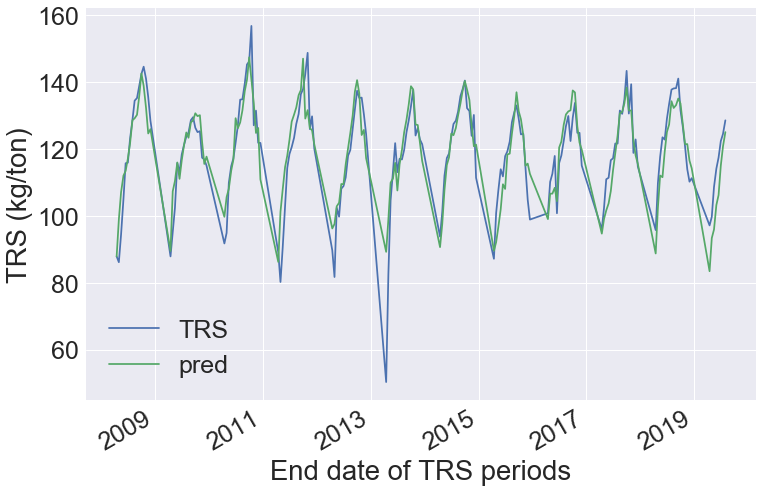

In [56]:
with_pred.set_index('end_date')

fig, ax = plt.subplots(figsize=(12,8))
with_pred.plot(x='end_date', y='TRS', ax=ax)
with_pred.plot(x='end_date', y='pred', ax=ax)
plt.xlabel('End date of TRS periods')
plt.ylabel('TRS (kg/ton)')
plt.show()

* Our model estimated TRS of all periods combined matched well with the Actual, especially during the peak TRS value periods

### Making predictions with the Model coefficients when a most recent period of TRS value was assumed to be available

In [47]:
# the cluster of TRS periods DOY 100-182
coef_early = model_list[0].params
coef_early.pop('intercept')

# the cluster of DOY periods 196-259
coef_mid = model_list[1].params
coef_mid.pop('intercept')

# the cluster of TRS periods DOY 273-350
coef_late = model_list[2].params
coef_late.pop('intercept')

223.9944653038518

* The coefficients of the linear regression models of different periods are stored above.
* Then limit the dataframe to the last 5 TRS periods, including the period to be predicted.
* Compute the differences in variables between periods.

In [48]:
recent_df = df_tog.sort_values(['year','DOY']).tail()
var_list = coef_mid.index.values
recent_diff = recent_df[var_list].diff()


* Calculate the predicted change in TRS from a previous period by using numpy's dot product function, inputting the ['lst','pet','trmm','ndvi'] differences and the coefficients.
* Since we are in the middle period already, use the middle period parameters.

In [49]:

recent_df['TRS_diff'] = np.dot(recent_diff.values, np.array(coef_mid).reshape(4, -1)).reshape(1,-1)[0]


* Finally, add the predicted change in TRS or *"TRS_diff"* to the previous periods to get the *"pred_TRS"*

In [50]:
recent_df['pred_TRS'] = [np.nan] + list(recent_df['TRS_diff'].values[1:] + recent_df['TRS'].values[:-1])
recent_df

,end_date,region_id,ndvi,doy,year,DOY,Year,pet,TRS,trmm,lst,TRS_diff,pred_TRS
189,2019-06-30 00:00:00+00:00,10408,0.637306,181,2019,181,2019,40.207118,122.388328,2.331407,25.639388,NaN,NaN
190,2019-07-15 00:00:00+00:00,10408,0.607610,196,2019,196,2019,35.686268,124.565572,27.600461,22.390140,3.377324,125.765652
191,2019-07-31 00:00:00+00:00,10408,0.562770,212,2019,212,2019,45.571318,128.611617,6.312553,23.372214,4.396572,128.962144
192,2019-08-15 00:00:00+00:00,10408,0.551480,227,2019,227,2019,50.138107,131.813981,7.815691,25.983064,2.236760,130.848377
193,2019-08-30 00:00:00+00:00,10408,0.502590,242,2019,242,2019,56.892302,NaN,4.906262,27.726499,5.931107,137.745087


In [50]:
# Calculate the Mean Squared Error as an evaluation
recent_df['pred_TRS'].subtract(recent_df['TRS']).abs().mean()

0.9218085147755156

In [52]:
# Calculate the Mean Squared Error as a fraction of the average TRS
0.9218/ (recent_df.loc[190:, 'TRS'].sum())

0.0023943406267777035

### Conclusion
* You can use this model to predict future periods of TRS where we have available Temperature (LST), Precipitation (TRMM), Potential Evapotranspiration (PET) and NDVI data.
* The example in this notebook predicted the TRS period with end_date "2019-08-15" to has 130.16 kg/ton (US short ton) of Total Recoverable Sugar content. The predictions using the same method for 3 previous periods got an average Mean Squared Error of 0.9 kg/ton , or 0.2% of the average actual next period's TRS